## Margin Recommender by Clustering

In this notebook we will try to predict recommended margin range for when a customer wants to by a new product by using unsupervised learning. 
More specifically we will first cluster products and then customers. After the clustering is performed we can calcuate the upper and lower bound for recommended margin with the following formula: 



We start off by importing the necessary libraries, and reading in the data.

In [158]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from itertools import combinations
from sklearn.decomposition import PCA



### Helper Functions
This section contains a variety of important functions used throughout the project. 

In [159]:
def get_coefficient_variation(data, feature): 
    '''
    The function calculates the coefficient of variation (CV) of the "Margin" for each category in the specified feature.

    Returns a sorted DataFrame with the mean, standard deviation, and CV for each category.
    '''

    grouped_data = data.groupby(feature)
    mean, std = grouped_data["Margin"].mean(), grouped_data["Margin"].std()
    df = pd.concat([mean, std], axis = 1).reset_index()
    df.columns = [feature, "Mean", "Std"]
    df["CoefficientOfVariation"] = (df["Std"]/df["Mean"])**2

    return df.sort_values(by = "CoefficientOfVariation")


In [160]:


def split_data(feature, data):
    '''
    Splits a DataFrame into multiple DataFrames based on the unique values of a specified categorical feature.

    Parameters:
    - feature: The column name to split the DataFrame by.
    - data: The DataFrame to split.

    Returns:
    - A dictionary where keys are unique feature values and values are the corresponding DataFrames.
    '''

    categories = list(data[feature].unique())
    dataframes = {}

    for c in categories: 
        df = data[data[feature] == c]
        dataframes[c] = df
        
    return dataframes


In [161]:
from datetime import datetime

'''
This cell contains all functions that are used to create new features used by the KMeans
algorithms to group products in clusters. 
More functions are needed to create more features to achieve better clustering results. 
'''

def add_average_margin_feature(dataframe):
    means = dataframe.groupby("ProductName")["Margin"].mean().reset_index()
    means.columns = ["ProductName", "MeanMargin"]
    new_df = pd.merge(means, dataframe, on = "ProductName")
    return new_df 
    

def add_average_cost_per_unit_feature(dataframe):
    dataframe.loc[:, "CostPerUnit"] = dataframe["Cost"]/dataframe["Quantity"]
    means = dataframe.groupby("ProductName")["CostPerUnit"].mean().reset_index()
    means.columns = ["ProductName", "MeanCostPerUnit"]
    new_df = pd.merge(means, dataframe, on = "ProductName")
    return new_df 

def add_average_sales_in_past_per_product(n_months, dataframe):
    dataframe["OrderDate"] = pd.to_datetime(dataframe["OrderDate"])
    last_date = dataframe["OrderDate"].max()
    n_months_ago = last_date - pd.DateOffset(months = n_months)
    filtered_data = dataframe[dataframe["OrderDate"] >= n_months_ago]
    meanSales = filtered_data.groupby("ProductName")["Sales"].mean().reset_index()
    meanSales.columns = ["ProductName", "AverageSalesPastMonths"]
    new_df = pd.merge(meanSales, dataframe, on = "ProductName")
    return new_df

def number_of_orders_per_product(dataframe): 
    product_order_counts = dataframe.groupby("ProductID")["OrderID"].count().reset_index()
    product_order_counts = product_order_counts.rename(columns = {"OrderID" : "NumberOfOrders"})
    dataframe = dataframe.merge(product_order_counts, on = "ProductID", how = "left")
    return dataframe
    
def add_total_sales_for_product(dataframe): 
    product_sales = dataframe.groupby("ProductID")["Sales"].sum().reset_index()
    product_sales.columns = ["ProductID", "TotalSales"]
    new_df = pd.merge(dataframe, product_sales, on = "ProductID", how = "left")
    return new_df

def add_total_cost_for_product(dataframe): 
    product_cost = dataframe.groupby("ProductID")["Cost"].sum().reset_index()
    product_cost.columns = ["ProductID", "TotalCost"]
    new_df = pd.merge(dataframe, product_cost, on = "ProductID", how = "left")
    return new_df

    

# Group products based on sales. Use the TotalRevenue. 
# Start by picking two features and see if there is any clustering. For example revenue and avg margin, or margin and number of orders. 
# Do not use average but sum. Also try changing the scaling method. 

In [162]:
def feature_engineering_preprocessing(dataframes: dict, scaler) -> dict:
    '''
    The function applies multiple feature engineering steps to each dataframe in the input dictionary. 

    It then returns a dictionary with the engineered dataframes. 
    '''
    
    result = {}

    for category in dataframes.keys(): 
        df = dataframes[category].copy()

        # Apply feature engineering steps
        df = number_of_orders_per_product(df)
        df = add_total_sales_for_product(df)
        df = add_total_cost_for_product(df)
        df = add_average_margin_feature(df)

        # Save the RowID before transformation
        row_id = df["RowID"].copy()

        # Select the features and apply scaling
        features = ["TotalCost", "TotalSales", "NumberOfOrders", "MeanMargin"]
        df_scaled = scaler.fit_transform(df[features])

        # Convert scaled data back to DataFrame
        df_scaled = pd.DataFrame(data=df_scaled, columns=scaler.get_feature_names_out())

        # Add the original RowID back to the scaled DataFrame
        df_scaled["RowID"] = row_id.values

        result[category] = df_scaled

    return result



In [163]:
def find_optimal_k(dataframes : dict): 
    '''
    Identifies the optimal number of clusters for KMeans using the elbow method and plotting the silhouette score. 

    Returns a plot of the interia score and silhouette score versus number of clusters for each of the dataframes 
    in the input dictionary. 
    '''
    ks = [x for x in range(2, 11)]
    inertia_scores = []
    silhouette_scores = []
    
    for category in dataframes.keys(): 
        data = dataframes[category].drop(["RowID"], axis = 1)
        inertia = []
        silhouette = []
        for k in ks: 
            model = KMeans(n_clusters = k, random_state = 42, init = 'k-means++')
            predicted = model.fit_predict(data)
            inertia.append(model.inertia_)
            silhouette.append(silhouette_score(data, predicted))

        inertia_scores.append(inertia)
        silhouette_scores.append(silhouette)
    
    fig, ax = plt.subplots(nrows = len(dataframes.keys()), ncols = 2, figsize = (15, 14), squeeze=False)
    for i in range(len(dataframes.keys())): 
        ax[i, 0].plot(ks, inertia_scores[i])
        ax[i, 1].plot(ks, silhouette_scores[i])
        ax[i, 0].set_xlabel("Number of Clusters")
        ax[i, 0].set_ylabel("Inertia")
        ax[i, 1].set_xlabel("Number of Clusters")
        ax[i, 1].set_ylabel("Silhouette Score")
        fig.text(0.5, 0.95 - (i*0.3), f"{list(dataframes.keys())[i]}", ha = 'center', fontsize = 14, weight = "bold")

    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [164]:
def visualize_clusters(model, data, title):
    '''
    The function visualizes clusters produced by a clustering model in 2D space, by 
    using t-SNE for dimensionality reduction. 

    Returns a 2D scatter plot of the data points colored by their predicted cluster labels. 
    '''
    embedding = TSNE(n_components=2,
        init="pca",
        max_iter=500,
        n_iter_without_progress=150,
        perplexity= 20,
        random_state=0)   

    data_2D = embedding.fit_transform(data)
    
    labels = model.labels_
    cmap = plt.get_cmap('tab10', model.n_clusters)

    unique_labels = set(labels)
    fig, ax = plt.subplots(figsize = (15, 10))

    for l in unique_labels: 
        cluster = data_2D[labels == l]
        ax.scatter(cluster[:, 0], cluster[:, 1], color = cmap(l), label = f"Cluster {l}")

    ax.legend()
    ax.set_title(title)
    plt.show()



In [165]:
def cluster_product_data(dataframes_scaled : dict, num_clusters : dict, vizualize = False): 
    '''
    For each dataframe in the dictionary that contains the scaled data, and the features that we proceed with we fit a KMeans
    model to each of the dataframes, with the number of clusters specified in the num_clusters dictionary. 
    '''
    for category in dataframes_scaled.keys(): 
        cluster_data = dataframes_scaled[category].drop(["RowID"], axis = 1)
        model = KMeans(n_clusters = num_clusters[category], init = "k-means++", random_state=42)
        predicted = model.fit_predict(cluster_data)
        
        if vizualize: visualize_clusters(model, cluster_data, category) 

        dataframes_scaled[category]["ProductCluster"] = predicted


### Product Clustering

First, we create two essential features for the project. One of these will be used later for feature engineering, while the other—margin—is the target feature that we aim to predict.

In [166]:
filepath = 'ECOMMRecords2020.csv'
data = pd.read_csv(filepath)
data_original = data.copy()

In [167]:
data["Cost"] = (data["Sales"] - data["Profit"])/data["Quantity"]
data["Margin"] = data["Profit"]/data["Sales"]

In [168]:

category = get_coefficient_variation(data, "Category") # We found that the it is best to split the data on category by looking at the coefficient of variation. 
sub_category = get_coefficient_variation(data, "SubCategory")

In [169]:
scaler = MinMaxScaler()
grouped_dataframes = split_data("Category", data)

In [170]:
# Conduct feature engineering and then scales the data so its ready to be fed into the KMeans algorithm. 
data = feature_engineering_preprocessing(grouped_dataframes, scaler)

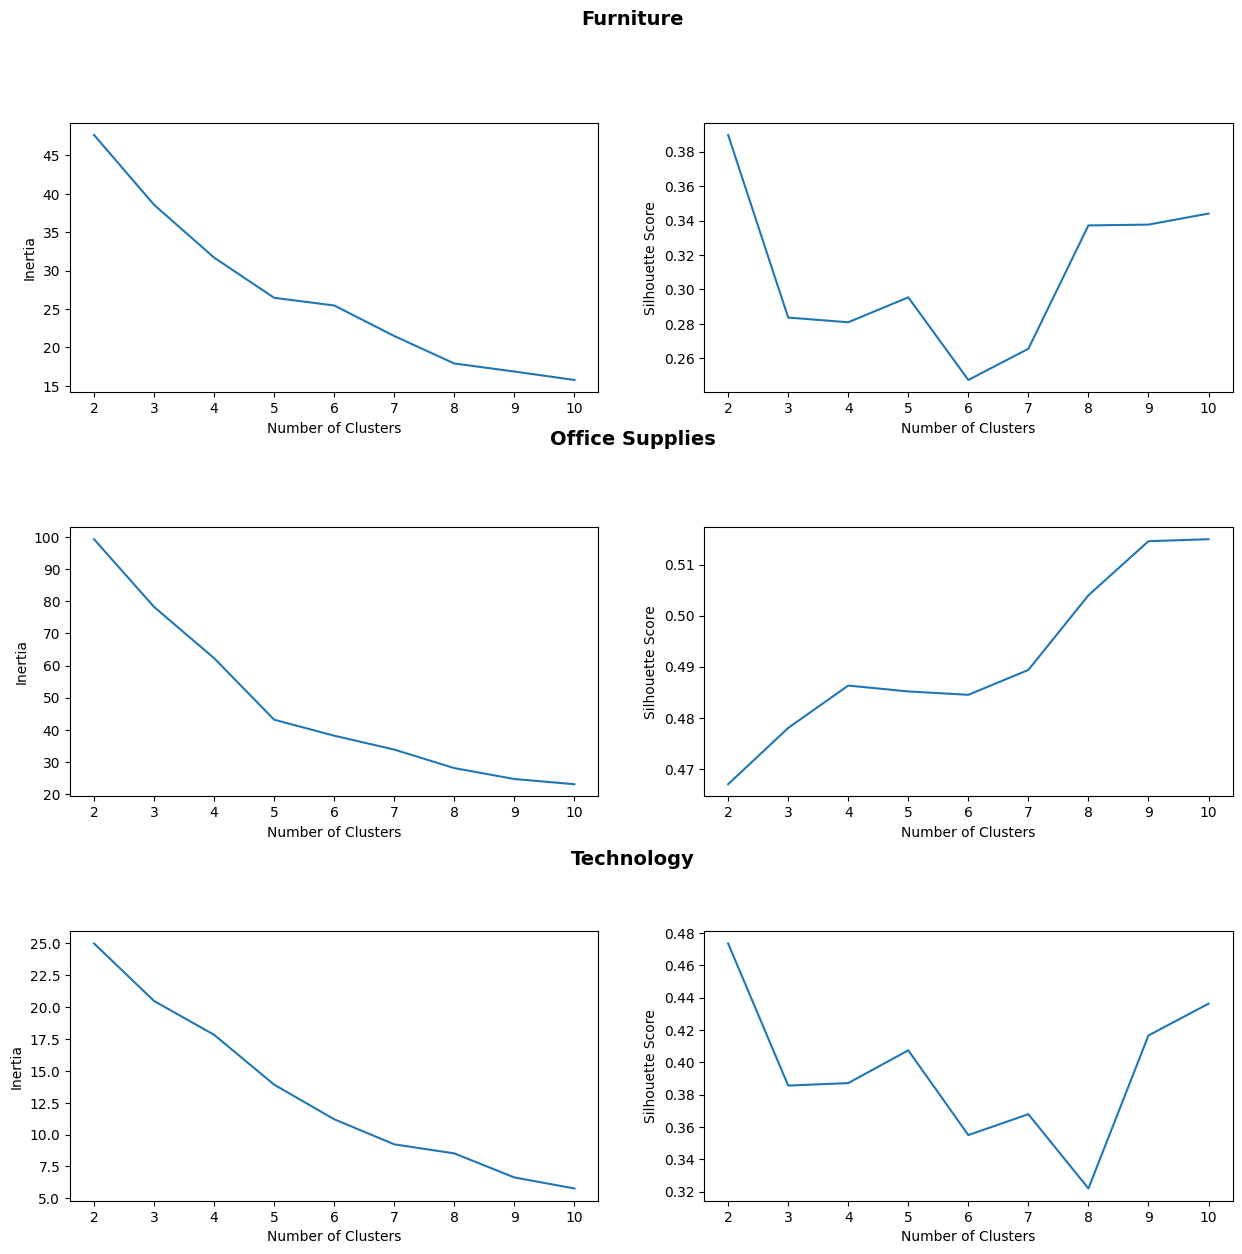

In [171]:
# Use the plots to identify which k is best to use for each category. 
find_optimal_k(data)

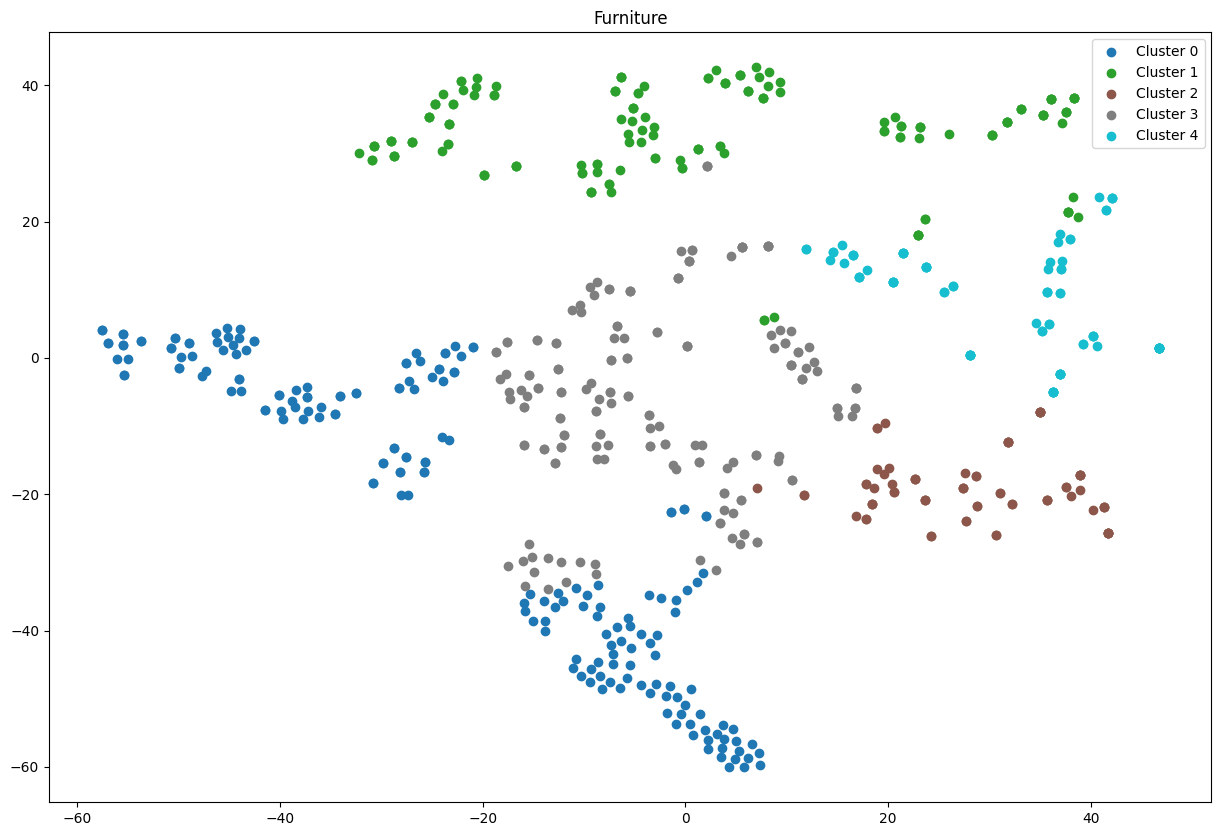

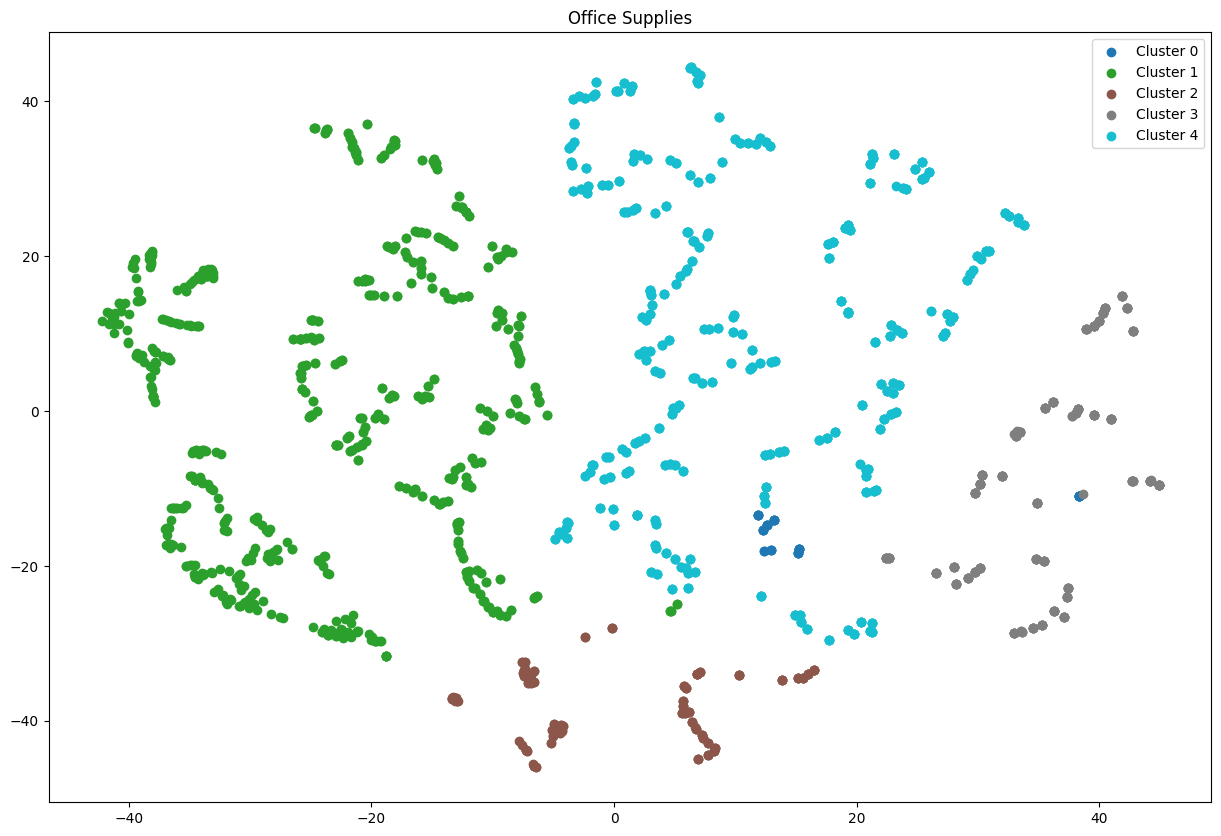

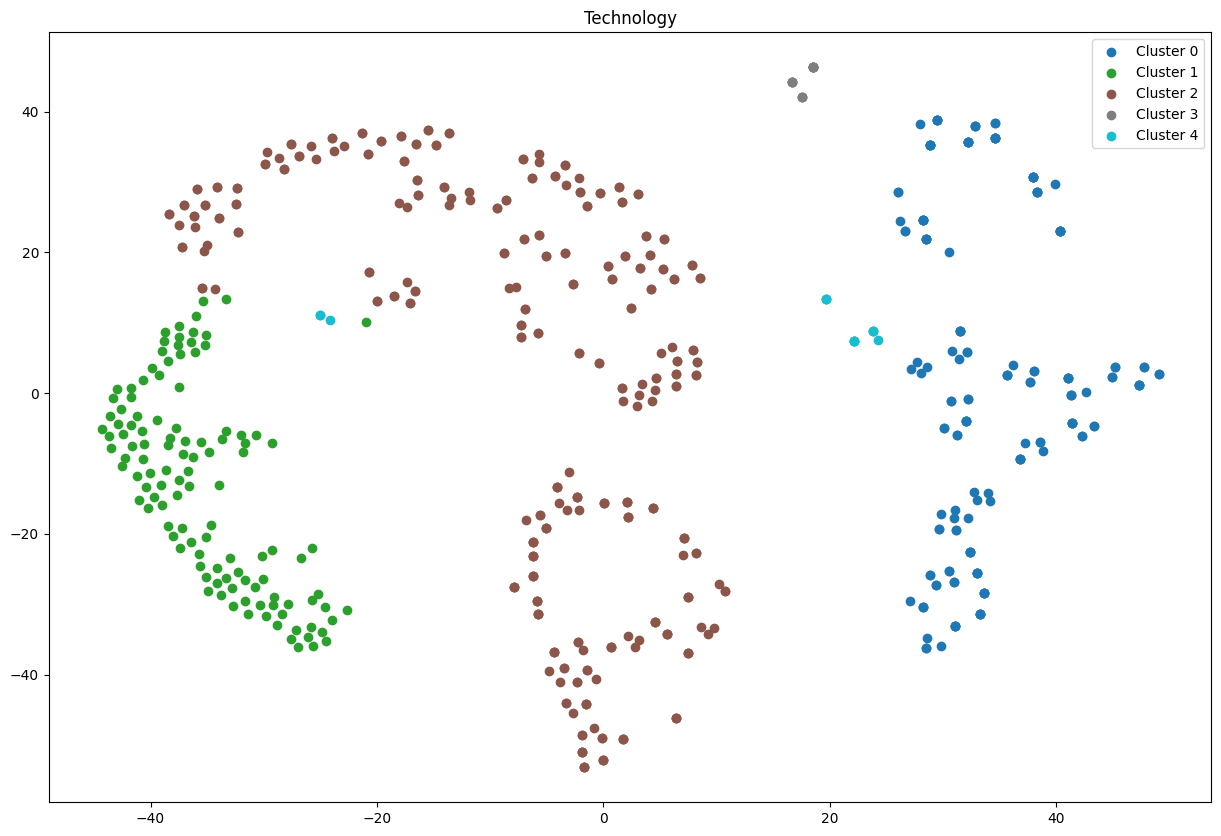

In [172]:
num_clusters = {"Technology" : 5, "Office Supplies" : 5, "Furniture" : 5}
cluster_product_data(data, num_clusters, vizualize=True)

### Customer Clustering

Compute revenue for costumer within each cluster. 

In [173]:
def inverse_scale_data_for_clustering(data : dict):
    '''
    When clustering the product data the data needed to be scaled using the MinMaxScaler for the KMeans clustering algorithm. 
    This function inverse scales the data to get the data back on the original scale from the scaler. 
    '''
    unscaled_dataframes = {}

    for category in data.keys(): 
        df_unscaled = scaler.inverse_transform(data[category].drop(["ProductCluster", "RowID"], axis = 1))
        df_unscaled = pd.DataFrame(data = df_unscaled, columns = scaler.get_feature_names_out())
        df_unscaled["RowID"] = data[category]["RowID"]
        df_unscaled["ProductCluster"] = data[category]["ProductCluster"]
        unscaled_dataframes[category] = df_unscaled

    return unscaled_dataframes


In [174]:
unscaled_product_data = inverse_scale_data_for_clustering(data)

In [175]:
unscaled_product_data["Technology"]

,TotalCost,TotalSales,NumberOfOrders,MeanMargin,RowID,ProductCluster
0,961.9926,5199.960,1.0,0.260000,6341,1
1,935.9928,1039.992,1.0,0.100000,6364,1
2,16.6110,67.800,1.0,0.020000,9861,1
3,300.0081,520.562,3.0,0.046944,9444,2
4,300.0081,520.562,3.0,0.046944,2465,2
...,...,...,...,...,...,...
619,39.1804,223.888,2.0,-0.225000,8912,2
620,28.0644,205.086,3.0,0.393333,6028,2
621,28.0644,205.086,3.0,0.393333,7739,2
622,28.0644,205.086,3.0,0.393333,3081,2


In [176]:
def get_data_for_customer_clustering(unscaled_product_data : dict): 
    customer_clustering_data = {}

    for category in unscaled_product_data.keys():
        customer_clustering_data[category] = pd.merge(grouped_dataframes[category], unscaled_product_data[category], on = "RowID", how = "left")
    
    return customer_clustering_data

In [177]:
customer_clustering_data = get_data_for_customer_clustering(unscaled_product_data)

In [178]:
customer_clustering_data["Technology"].head()

,OrderDate,RowID,OrderID,ShipMode,CustomerID,Segment,Country,City,State,PostalCode,...,Quantity,Discount,Profit,Cost,Margin,TotalCost,TotalSales,NumberOfOrders,MeanMargin,ProductCluster
0,2020-01-02,1341,CA-2017-113481,First Class,AS-10045,Corporate,United States,Jacksonville,North Carolina,28540,...,2,0.5,-27.8280,361.7640,-0.040000,361.7640,695.700,1.0,-0.040000,1
1,2020-01-02,9686,CA-2017-118668,Second Class,FW-14395,Corporate,United States,Los Angeles,California,90032,...,1,0.0,5.8065,10.7835,0.350000,43.1340,172.536,4.0,0.309375,0
2,2020-01-07,978,CA-2017-159366,First Class,BW-11110,Corporate,United States,Detroit,Michigan,48205,...,2,0.1,679.9960,1189.9930,0.222222,2379.9860,5609.967,2.0,-0.555556,4
3,2020-01-14,1184,CA-2017-138779,First Class,RB-19570,Consumer,United States,Jacksonville,North Carolina,28540,...,5,0.2,0.6930,1.4454,0.087500,1.4454,7.920,1.0,0.087500,1
4,2020-01-14,4165,US-2017-106131,First Class,TP-21565,Corporate,United States,Aurora,Colorado,80013,...,7,0.2,-14.7931,26.2653,-0.087500,52.5306,259.634,2.0,0.021250,2


In [179]:
def calculate_total_revenue(customer_clustering_data : dict):
    result = {}

    for category in customer_clustering_data.keys():
        data = customer_clustering_data[category]
        cluster_revenues_customer = data.groupby(["CustomerID", "ProductCluster"])["TotalSales"].sum()
        cluster_revenues_customer = cluster_revenues_customer.unstack(fill_value = 0)
        cluster_revenues_customer.columns = [f"totalRevenue_PC_{col}" for col in cluster_revenues_customer]
        cluster_revenues_customer = cluster_revenues_customer.reset_index()

        result[category] = pd.merge(data, cluster_revenues_customer, on = "CustomerID", how = "left")
    
    return result


In [180]:
customer_clustering_data = calculate_total_revenue(customer_clustering_data)

In [181]:
customer_clustering_data["Technology"].head()

,OrderDate,RowID,OrderID,ShipMode,CustomerID,Segment,Country,City,State,PostalCode,...,TotalCost,TotalSales,NumberOfOrders,MeanMargin,ProductCluster,totalRevenue_PC_0,totalRevenue_PC_1,totalRevenue_PC_2,totalRevenue_PC_3,totalRevenue_PC_4
0,2020-01-02,1341,CA-2017-113481,First Class,AS-10045,Corporate,United States,Jacksonville,North Carolina,28540,...,361.7640,695.700,1.0,-0.040000,1,0.000,695.700,3359.958,0.000,0.000
1,2020-01-02,9686,CA-2017-118668,Second Class,FW-14395,Corporate,United States,Los Angeles,California,90032,...,43.1340,172.536,4.0,0.309375,0,172.536,0.000,0.000,0.000,0.000
2,2020-01-07,978,CA-2017-159366,First Class,BW-11110,Corporate,United States,Detroit,Michigan,48205,...,2379.9860,5609.967,2.0,-0.555556,4,0.000,27.192,0.000,0.000,5609.967
3,2020-01-14,1184,CA-2017-138779,First Class,RB-19570,Consumer,United States,Jacksonville,North Carolina,28540,...,1.4454,7.920,1.0,0.087500,1,0.000,7.920,0.000,3763.298,0.000
4,2020-01-14,4165,US-2017-106131,First Class,TP-21565,Corporate,United States,Aurora,Colorado,80013,...,52.5306,259.634,2.0,0.021250,2,0.000,0.000,259.634,0.000,0.000


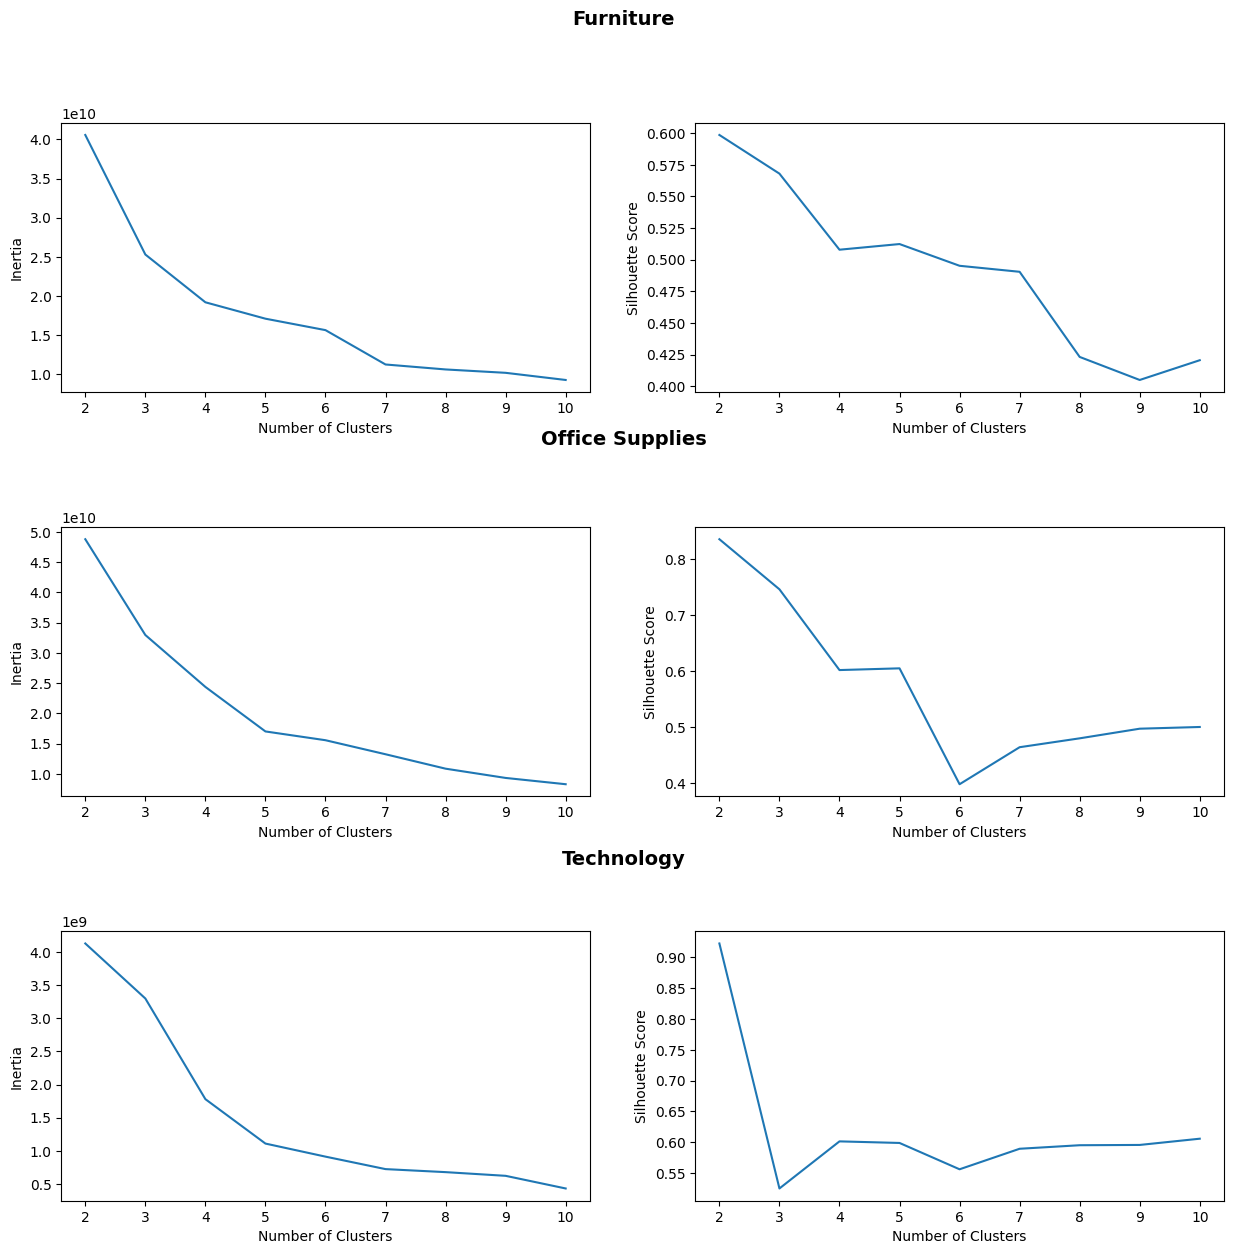

In [182]:
features = ["RowID", "totalRevenue_PC_0",	"totalRevenue_PC_1",	"totalRevenue_PC_2",	"totalRevenue_PC_3",	"totalRevenue_PC_4"]
customer_clustering_data_revenues = {key : df[features] for key, df in customer_clustering_data.items()}
find_optimal_k(customer_clustering_data_revenues)

In [183]:
def cluster_customer_data(customer_clustering_data_revenues : dict, n_clusters : dict, vizualise = True):

    for category in customer_clustering_data_revenues.keys():
        data = customer_clustering_data_revenues[category].drop(["RowID"], axis = 1)
        scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data)

        model = KMeans(n_clusters=n_clusters[category], init = "k-means++")
        predictions = model.fit_predict(data_scaled)

        if vizualise: visualize_clusters(model, data_scaled, category)

        customer_clustering_data_revenues[category]["CustomerCluster"] = predictions




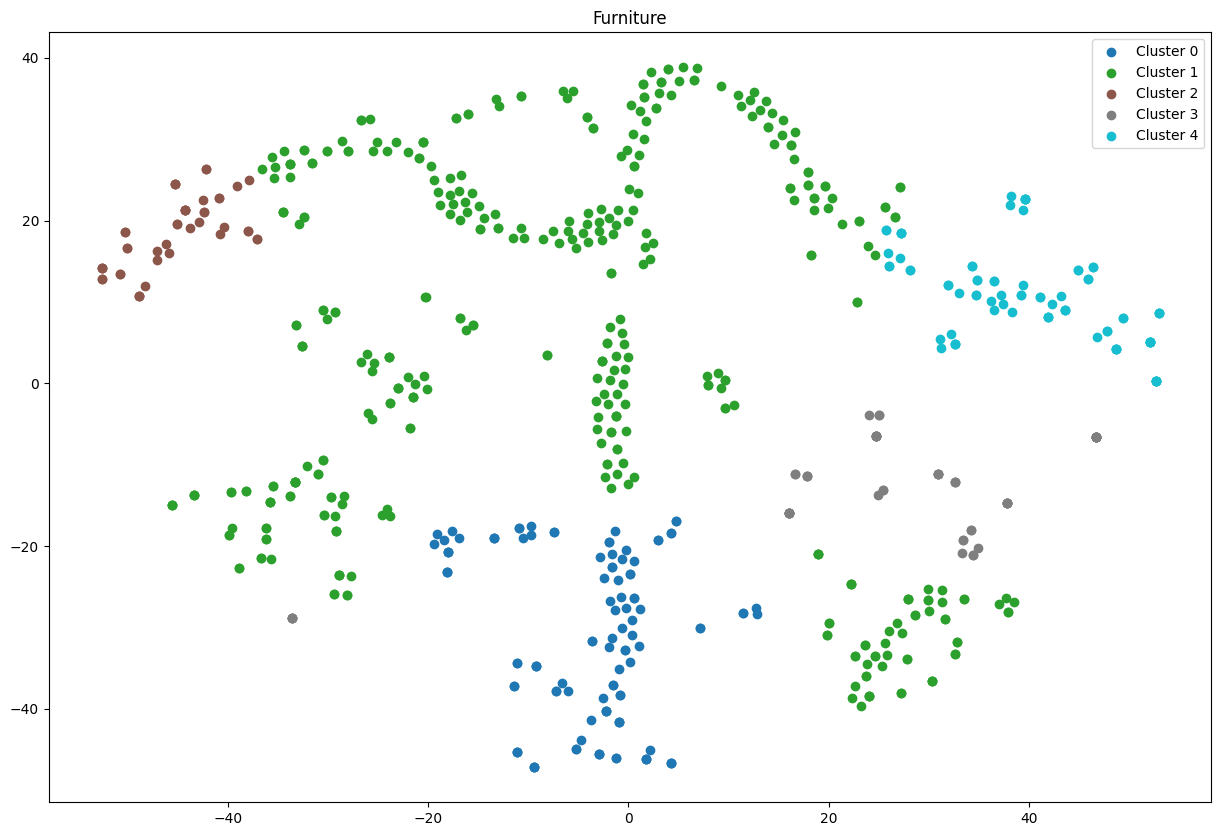

/var/folders/m_/52cv0jg50ks4sf87x_jwf8x40000gn/T/ipykernel_2489/2607570064.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_clustering_data_revenues[category]["CustomerCluster"] = predictions


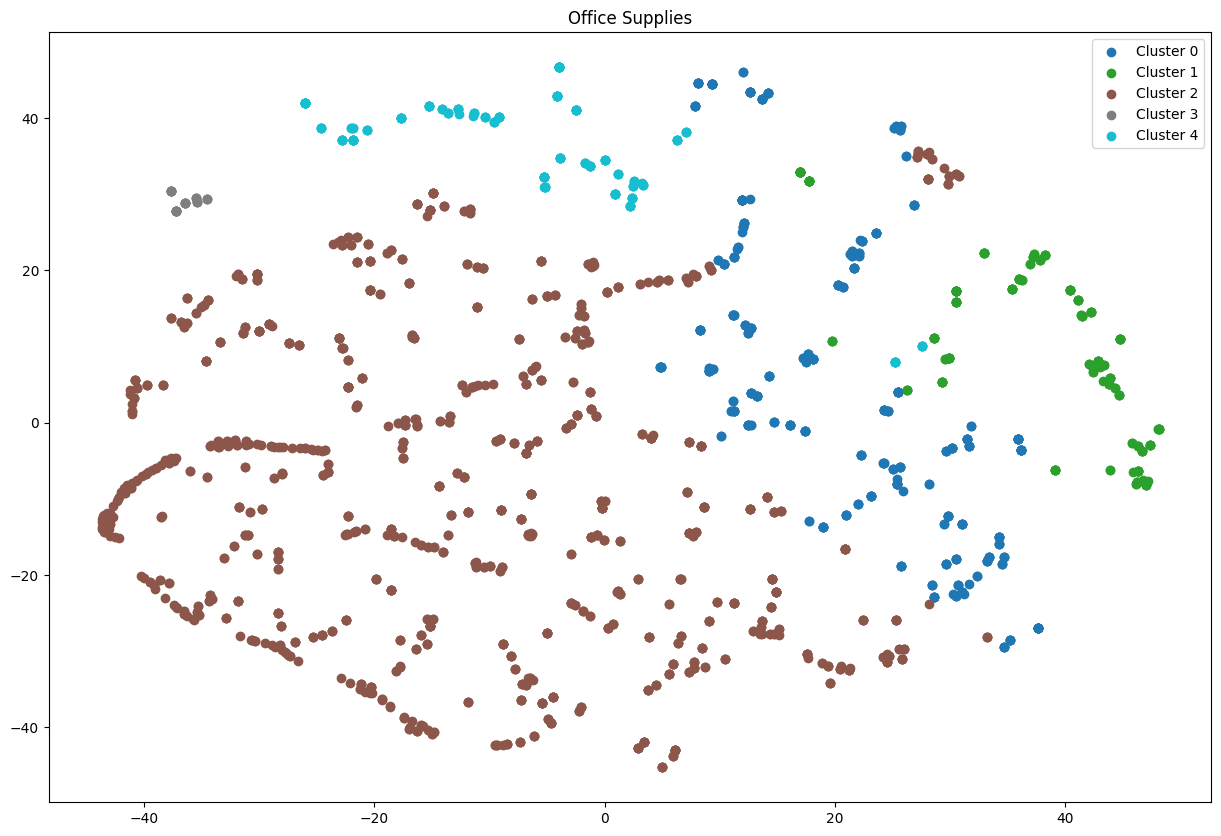

/var/folders/m_/52cv0jg50ks4sf87x_jwf8x40000gn/T/ipykernel_2489/2607570064.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_clustering_data_revenues[category]["CustomerCluster"] = predictions


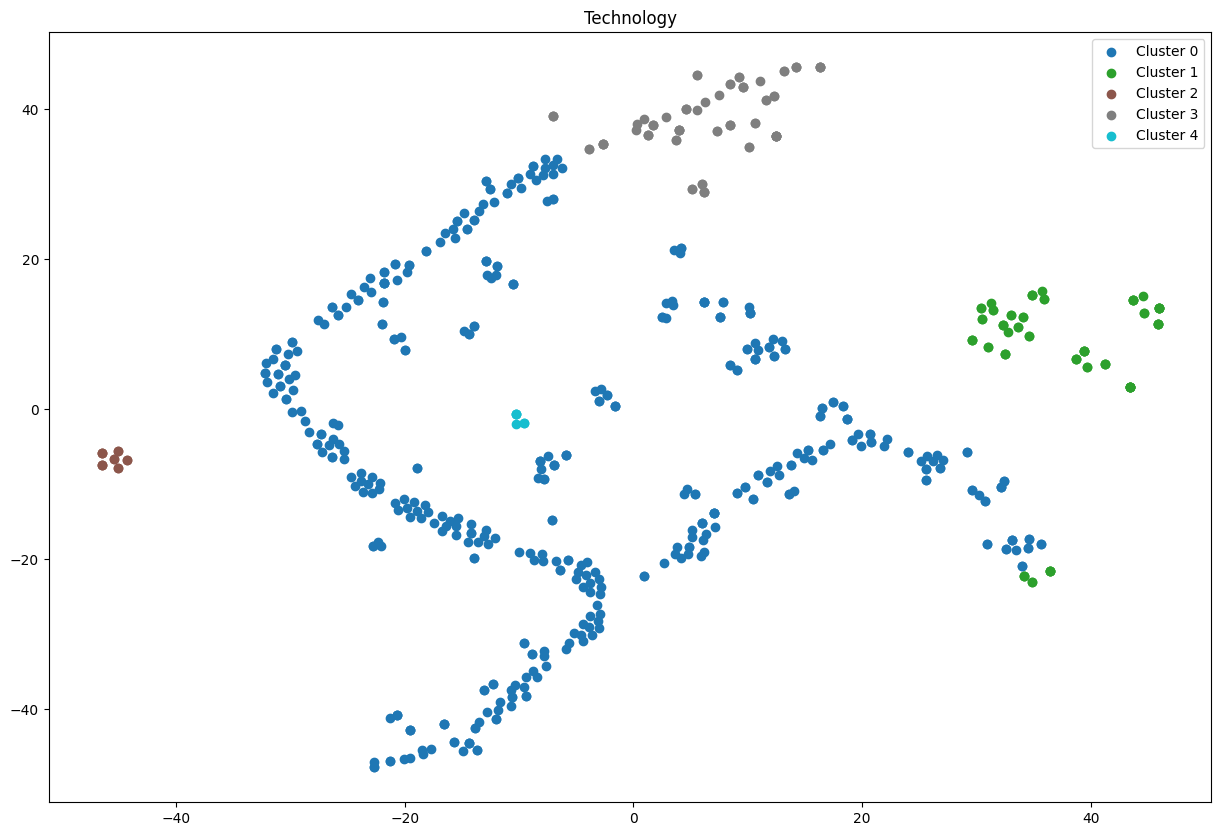

/var/folders/m_/52cv0jg50ks4sf87x_jwf8x40000gn/T/ipykernel_2489/2607570064.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_clustering_data_revenues[category]["CustomerCluster"] = predictions


In [184]:
n_clusters = {"Technology" : 5, "Furniture" : 5, "Office Supplies" : 5}
cluster_customer_data(customer_clustering_data_revenues, n_clusters)

In [192]:
customer_clustering_data["Technology"].head()

,OrderDate,RowID,OrderID,ShipMode,CustomerID,Segment,Country,City,State,PostalCode,...,TotalCost,TotalSales,NumberOfOrders,MeanMargin,ProductCluster,totalRevenue_PC_0,totalRevenue_PC_1,totalRevenue_PC_2,totalRevenue_PC_3,totalRevenue_PC_4
0,2020-01-02,1341,CA-2017-113481,First Class,AS-10045,Corporate,United States,Jacksonville,North Carolina,28540,...,361.7640,695.700,1.0,-0.040000,1,0.000,695.700,3359.958,0.000,0.000
1,2020-01-02,9686,CA-2017-118668,Second Class,FW-14395,Corporate,United States,Los Angeles,California,90032,...,43.1340,172.536,4.0,0.309375,0,172.536,0.000,0.000,0.000,0.000
2,2020-01-07,978,CA-2017-159366,First Class,BW-11110,Corporate,United States,Detroit,Michigan,48205,...,2379.9860,5609.967,2.0,-0.555556,4,0.000,27.192,0.000,0.000,5609.967
3,2020-01-14,1184,CA-2017-138779,First Class,RB-19570,Consumer,United States,Jacksonville,North Carolina,28540,...,1.4454,7.920,1.0,0.087500,1,0.000,7.920,0.000,3763.298,0.000
4,2020-01-14,4165,US-2017-106131,First Class,TP-21565,Corporate,United States,Aurora,Colorado,80013,...,52.5306,259.634,2.0,0.021250,2,0.000,0.000,259.634,0.000,0.000


In [185]:
customer_clustering_data_revenues["Technology"].head()

,RowID,totalRevenue_PC_0,totalRevenue_PC_1,totalRevenue_PC_2,totalRevenue_PC_3,totalRevenue_PC_4,CustomerCluster
0,1341,0.000,695.700,3359.958,0.000,0.000,3
1,9686,172.536,0.000,0.000,0.000,0.000,0
2,978,0.000,27.192,0.000,0.000,5609.967,0
3,1184,0.000,7.920,0.000,3763.298,0.000,2
4,4165,0.000,0.000,259.634,0.000,0.000,0


In [195]:
def get_final_dataframe(customer_clustering_data_with_clusters : dict) -> dict:
    result = {}
    for category in customer_clustering_data_with_clusters.keys():
        data = customer_clustering_data_with_clusters[category][["RowID", "CustomerCluster"]]
        data = pd.merge(customer_clustering_data[category], data, on = "RowID", how = "left")
        data = data[["CustomerCluster", "Margin"]]
        result[category] = data
    
    return result

In [196]:
final_dataframes = get_final_dataframe(customer_clustering_data_revenues)

In [202]:
technology_data_array = np.array(list(final_dataframes["Technology"].itertuples(index = False, name = None)), 
                                 dtype=[("cluster_id", int), ("margin", float)])


In [204]:
import numpy as np

# Sample data: array of tuples with 'cluster_id' and 'margin'
# bytt ut data med customercluster info
data = technology_data_array

# Extract 'margin' and 'cluster_id' arrays
margins = data['margin']
cluster_ids = data['cluster_id']

# Get unique cluster IDs
unique_clusters = np.unique(cluster_ids)

# Dictionary to store results
cluster_percentiles = {}

# Calculate 40th and 75th percentiles for each cluster
for cluster in unique_clusters:
    # Filter margins for the current cluster
    cluster_margins = margins[cluster_ids == cluster]

    # Calculate 40th and 75th percentiles within the cluster
    percentile_40 = np.percentile(cluster_margins, 40)
    percentile_75 = np.percentile(cluster_margins, 75)

    # Calculate percentile ranks for the overall data
    percentile_40_rank = percentile_rank(percentile_40, margins)
    percentile_75_rank = percentile_rank(percentile_75, margins)

    # Store the results
    cluster_percentiles[cluster] = {
        '40th_percentile_margin': percentile_40,
        '40th_percentile_rank': percentile_40_rank,
        '75th_percentile_margin': percentile_75,
        '75th_percentile_rank': percentile_75_rank
    }

# Display the results
for cluster, stats in cluster_percentiles.items():
    print(f"Cluster {cluster}:")
    print(f"  40th Percentile Margin: {stats['40th_percentile_margin']} (Percentile: {stats['40th_percentile_rank']:.2f}%)")
    print(f"  75th Percentile Margin: {stats['75th_percentile_margin']} (Percentile: {stats['75th_percentile_rank']:.2f}%)\n")






Cluster 0:
  40th Percentile Margin: 0.1125 (Percentile: 37.50%)
  75th Percentile Margin: 0.3 (Percentile: 71.96%)

Cluster 1:
  40th Percentile Margin: 0.1125 (Percentile: 37.50%)
  75th Percentile Margin: 0.29 (Percentile: 69.23%)

Cluster 2:
  40th Percentile Margin: 0.11600000000000002 (Percentile: 40.06%)
  75th Percentile Margin: 0.39749999999999996 (Percentile: 89.74%)

Cluster 3:
  40th Percentile Margin: 0.21250000000000002 (Percentile: 56.09%)
  75th Percentile Margin: 0.37124999999999997 (Percentile: 87.82%)

Cluster 4:
  40th Percentile Margin: 0.3 (Percentile: 71.96%)
  75th Percentile Margin: 0.4475 (Percentile: 95.67%)

